<a href="https://colab.research.google.com/github/pelinsuciftcioglu/VAE/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Variational Auto-Encoder (VAE)**

VAE implementation inspired by:
- [Tomczak, J. M. (2021). Introduction to Deep Generative Modeling.](https://https://github.com/jmtomczak/intro_dgm)
- [CreativeAI: Deep Learning for Graphics Tutorial Code
](https://github.com/smartgeometry-ucl/dl4g/blob/master/variational_autoencoder.ipynb)







```
pip install --upgrade jupyter_http_over_ws>=0.0.7 && jupyter serverextension enable --py jupyter_http_over_ws

jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --NotebookApp.port_retries=0
```



In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
import torch.utils
import torch.distributions
import torchvision
from torch import autograd  # TO USE "with autograd.detect_anomaly():"
import numpy as np
import matplotlib.pyplot as plt
import math
import random


import os

use_gpu = True

In [2]:
# CUSTOM TRANFORM FOR THE DATA WITHOUT NORMALIZING
"""
https://github.com/pytorch/vision/blob/a839796328cf4f789c9de5da0b3367b742b5a00c/torchvision/transforms/transforms.py

"""

import numbers
import warnings
from enum import Enum

from PIL import Image

from typing import List, Tuple, Any, Optional

try:
    import accimage
except ImportError:
    accimage = None

class ToTensor:
    def __call__(self, pic):
        """
        Args:
            pic (PIL Image or numpy.ndarray): Image to be converted to tensor.
        Returns:
            Tensor: Converted image.
        """
        return to_tensor(np.array(pic))

    def __repr__(self):
        return self.__class__.__name__ + '()'

def to_tensor(pic):
    """Convert a ``PIL Image`` or ``numpy.ndarray`` to tensor.
    This function does not support torchscript.
    See :class:`~torchvision.transforms.ToTensor` for more details.
    Args:
        pic (PIL Image or numpy.ndarray): Image to be converted to tensor.
    Returns:
        Tensor: Converted image.
    """
    default_float_dtype = torch.get_default_dtype()

    if isinstance(pic, np.ndarray):
        # handle numpy array
        if pic.ndim == 2:
            pic = pic[:, :, None]

        img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()
        # backward compatibility
        if isinstance(img, torch.ByteTensor):
            return img.to(dtype=default_float_dtype)
        else:
            return img

    if accimage is not None and isinstance(pic, accimage.Image):
        nppic = np.zeros([pic.channels, pic.height, pic.width], dtype=np.float32)
        pic.copyto(nppic)
        return torch.from_numpy(nppic).to(dtype=default_float_dtype)

    # handle PIL Image
    mode_to_nptype = {'I': np.int32, 'I;16': np.int16, 'F': np.float32}
    img = torch.from_numpy(
        np.array(pic, mode_to_nptype.get(pic.mode, np.uint8), copy=True)
    )

    if pic.mode == '1':
        img = 255 * img
    img = img.view(pic.size[1], pic.size[0], len(pic.getbands()))
    # put it from HWC to CHW format
    img = img.permute((2, 0, 1)).contiguous()
    if isinstance(img, torch.ByteTensor):
        return img.to(dtype=default_float_dtype)
    else:
        return img

In [3]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
from torchvision.datasets import MNIST

def load_static_mnist(batch_size, is_binary = True, use_training_data_init = True):
    # set args
    input_size = [1, 28, 28]
    number_components = 1

    if is_binary:
      # start processing
      def lines_to_np_array(lines):
          return np.array([[int(i) for i in line.split()] for line in lines])
      with open(os.path.join('data', 'MNIST_static', 'binarized_mnist_train.amat')) as f:
          lines = f.readlines()
      x_train = lines_to_np_array(lines).astype('float32')
      with open(os.path.join('data', 'MNIST_static', 'binarized_mnist_valid.amat')) as f:
          lines = f.readlines()
      x_val = lines_to_np_array(lines).astype('float32')
      with open(os.path.join('data', 'MNIST_static', 'binarized_mnist_test.amat')) as f:
          lines = f.readlines()

      x_test = lines_to_np_array(lines).astype('float32')

      # shuffle train data
      np.random.shuffle(x_train)

      # idle y's
      y_train = np.zeros((x_train.shape[0], 1))
      y_val = np.zeros((x_val.shape[0], 1))
      y_test = np.zeros((x_test.shape[0], 1))


    else:
      train_dataloader = DataLoader(MNIST(root='./data/MNIST', download=True, train=True, transform=transforms.Compose([ToTensor()])), batch_size=batch_size, shuffle=True)
      test_dataloader = DataLoader(MNIST('./data/MNIST', train=False, download=True, transform=transforms.Compose([ToTensor()])), batch_size=batch_size, shuffle=False)

      x_train = train_dataloader.dataset.data.float().numpy()
      x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1] * x_train.shape[2] ) )

      y_train = np.array( train_dataloader.dataset.targets.float().numpy(), dtype=int)

      x_test = test_dataloader.dataset.data.float().numpy()
      x_test = np.reshape( x_test, (x_test.shape[0], x_test.shape[1] * x_test.shape[2] ) )

      y_test = np.array( test_dataloader.dataset.targets.float().numpy(), dtype=int)

      # validation set
      x_val = x_train[50000:60000]
      y_val = np.array(y_train[50000:60000], dtype=int)
      x_train = x_train[0:50000]
      y_train = np.array(y_train[0:50000], dtype=int)

    # pytorch data loader
    train = TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train))
    train_dataloader = DataLoader(train, batch_size=batch_size, shuffle=True)

    validation = TensorDataset(torch.from_numpy(x_val).float(), torch.from_numpy(y_val))
    val_dataloader = DataLoader(validation, batch_size=batch_size, shuffle=False)

    test = TensorDataset(torch.from_numpy(x_test).float(), torch.from_numpy(y_test))
    test_dataloader = DataLoader(test, batch_size=batch_size, shuffle=True)


    # setting pseudo-inputs inits
    if use_training_data_init == 1:
      pseudoinputs_std = 0.01
      init = x_train[0:number_components].T
      pseudoinputs_mean = torch.from_numpy( init + pseudoinputs_std * np.random.randn(np.prod(input_size), number_components) ).float()
    else:
      pseudoinputs_mean = 0.05
      pseudoinputs_std = 0.01

    return train_dataloader, val_dataloader, test_dataloader

In [4]:
class_names = ['Zero', 'One', 'Two', 'Three', 'Four', 'Five', 'Six', 'Seven', 'Eight', 'Nine']

def plot_data(file_name, num_images, images, labels=None, is_binary=True, reconstructed=False):
  
  color = "gray_r"
  
  if reconstructed:
    if not is_binary:
      color = "gray"
      images = torch.ceil(images * 255)

  if is_binary:
    labels = None

  images = images.cpu()

  images = images.detach().numpy()

  grid = math.ceil(math.sqrt(num_images))
  plt.figure(figsize=(grid*2,grid*2))
  for i in range(num_images):
      plt.subplot(grid,grid,i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)     
      plt.imshow(images[i].reshape(28,28), cmap=color)
      if labels != None:
        plt.xlabel(class_names[labels[i]])      
  plt.savefig(file_name)
  plt.close()

In [5]:
PI = torch.from_numpy(np.asarray(np.pi))
EPS = 1.e-5

# DISTRBUTION FOR THE DATA (INPUT)

def log_categorical(x, x_new, num_classes, reduction=None, dim=None):
    x_one_hot = F.one_hot(x.long(), num_classes)
    log_p = x_one_hot * torch.log(torch.clamp(x_new, EPS, 1. - EPS))
    if reduction == 'avg':
        return torch.mean(log_p, dim)
    elif reduction == 'sum':
        # 32 x 784 x 256
        return torch.sum(log_p, dim)
        # 32 x 784
    else:
        return log_p

def log_bernoulli(x, x_new, reduction=None, dim=None):
    x_new = torch.clamp(x_new, EPS, 1. - EPS)
    log_p = x * torch.log(x_new) + (1. - x) * torch.log(1. - x_new)
    if reduction == 'avg':
        return torch.mean(log_p, dim)
    elif reduction == 'sum':
        return torch.sum(log_p, dim)
    else:
        return log_p

# DISTRIBUTION FOR THE VARIATIONAL INFERENCE

def log_normal_diag(x, mu, log_var, reduction=None, dim=None):
    D = x.shape[1]
    log_p = -0.5 * D * torch.log(2. * PI) - 0.5 * log_var - 0.5 * torch.exp(-log_var) * (x - mu)**2.
    if reduction == 'avg':
        return torch.mean(log_p, dim)
    elif reduction == 'sum':
        return torch.sum(log_p, dim)
    else:
        return log_p


# PRIOR DISTRIBUTIONS for p(z)

def log_standard_normal(x, reduction=None, dim=None):
    D = x.shape[1]
    log_p = -0.5 * D * torch.log(2. * PI) - 0.5 * x**2.
    if reduction == 'avg':
        return torch.mean(log_p, dim)
    elif reduction == 'sum':
        return torch.sum(log_p, dim)
    else:
        return log_p

In [6]:
class Encoder(nn.Module):
    def __init__(self, D, H, L):
        super(Encoder, self).__init__()

        self.encoder_net = nn.Sequential(nn.Linear(D, H), nn.LeakyReLU(), nn.Linear(H, H), nn.LeakyReLU(), nn.Linear(H, 2*L))

    def encode(self, x):
      # Flatten the input to a single dimension
      x = torch.flatten(x, start_dim=1)

      mu, log_var = self.forward(x)

      return x, mu, log_var

    def forward(self, x):
      x = x.to(device)

      h = self.encoder_net(x)

      # Split the neural network output for means and log variances
      mu, log_var =  torch.chunk(h, 2, dim=1)
      return mu, log_var

    def sample(self, mu, log_var):
      std = torch.exp(0.5 * log_var)
      # Sample epsilon ~ N(0,I)
      eps = torch.randn_like(std)
      # Reparameterization trick
      z = mu + eps * std
      return z

    def log_prob(self, mu, log_var, z):
      return log_normal_diag(z, mu, log_var)

In [7]:
class Decoder(nn.Module):
    def __init__(self, D, H, L, distribution, num_vals):
        super(Decoder, self).__init__()
        self.D = D
        self.distribution = distribution
        self.num_vals = num_vals

        self.decoder_net = nn.Sequential(nn.Linear(L, H), nn.LeakyReLU(), nn.Linear(H, H), nn.LeakyReLU(), nn.Linear(H, D * num_vals))

    def decode(self, z):
      x_new = self.forward(z)

      return x_new

    def forward(self, z):
      x_new = self.decoder_net(z)
      
      if self.distribution == 'categorical':
        b = x_new.shape[0]
        d = self.D
        x_new = x_new.reshape(b, d, self.num_vals)
        return torch.softmax(x_new, 2)
      
      elif self.distribution == 'bernoulli':
        return torch.sigmoid(x_new)

    def sample(self, z):
        x_generated = self.decode(z)

        if self.distribution == 'categorical':
            b = x_generated.shape[0]
            m = x_generated.shape[1]
            x_generated = x_generated.view(b, -1, self.num_vals)
            p = x_generated.view(-1, self.num_vals)
            x_generated = torch.multinomial(p, num_samples=1).view(b, m)
        elif self.distribution == 'bernoulli':
            x_generated = torch.bernoulli(x_generated)

        return x_generated

In [8]:
class Prior(nn.Module):
    def __init__(self, L, prior_distribution):
        super(Prior, self).__init__()
        self.L = L
        self.distribution = prior_distribution

    def sample(self, batch_size):
        z = torch.randn((batch_size, self.L))
        return z

    def log_prob(self, z):
      if (self.distribution == 'standard normal'):
        return log_standard_normal(z)

      # elif self.distribution == ''
        # return log____(z)

In [9]:
class VAE(nn.Module):
  def __init__(self, D, H, L, distribution, num_vals, prior_distribution):
        super(VAE, self).__init__()
        self.encoder = Encoder(D, H, L)
        self.decoder = Decoder(D, H, L, distribution, num_vals)
        self.prior = Prior(L, prior_distribution)


        self.num_vals = num_vals
        self.distribution = distribution
  
  def forward(self, x, reduction='avg'):
        
        x, mu, log_var = self.encoder.encode(x)

        # Sample z based on the mean and log variance
        z = self.encoder.sample(mu, log_var)

        # Decode the latent representation and reconstruct input
        x_new = self.decoder.decode(z)

        # Reconstructed images based on the highest probability assigned for each pixel
        if (self.distribution == 'categorical'):
          x_reconstructed, idx = torch.max(x_new, dim=2)
        else:
          x_reconstructed = torch.bernoulli(x_new)

        # Evidence Lower Bound
        ELBO = self.loss(x, x_new, z, mu, log_var, reduction)

        return x_reconstructed, ELBO
  
  def loss(self, x, x_new, z, mu, log_var, reduction='avg'):
    # Reconstruction Error
    RE = self.log_prob(x, x_new)

    # KL-Divergence
    KL = (self.prior.log_prob(z) - self.encoder.log_prob(mu, log_var, z)).sum(-1)

    if reduction == 'sum':
      # For testing sum all the loss values in the batch then take the average in the training loop
      return -(RE + KL).sum() 
    else:
      # For training calculate the mean of the loss values of the batch
      return -(RE + KL).mean()


  def log_prob(self, x, x_new):

    if self.distribution == 'categorical':
      log_prob = log_categorical(x, x_new, self.num_vals, reduction='sum', dim=-1).sum(-1)  # (32)

    elif self.distribution == 'bernoulli':
      log_prob = log_bernoulli(x, x_new, reduction='sum', dim=-1)

    return log_prob

  def sample(self, batch_size=128):
    z = self.prior.sample(batch_size=batch_size)

    z = z.to(device)  # FOR GENERATING SAMPLES

    return self.decoder.sample(z)

In [10]:
# DISTRUBUTION FOR THE INPUT DATA
likelihood_type = 'bernoulli'

if likelihood_type == 'categorical':
    num_vals = 256
    is_binary = False
elif likelihood_type == 'bernoulli':
    num_vals = 1
    is_binary = True

prior_distribution = 'standard normal'

In [11]:
D = 28*28 # INPUT DATA DIMENSIONALITY
H = 256   # HIDDEN LAYER NODES
L = 32    # LATENT VARIABLES DIMENSIONALITY

learning_rate = 0.001
num_epochs = 100

batch_size = 64

In [12]:
model = VAE(D, H, L, likelihood_type, num_vals, prior_distribution)

device = torch.device("cuda" if use_gpu and torch.cuda.is_available() else "cpu")
model = model.to(device)

# ADAM OPTIMIZER
optimizer = torch.optim.Adam([p for p in model.parameters() if p.requires_grad == True], lr=learning_rate)

In [13]:
results_dir = 'Results/'
if not(os.path.exists(results_dir)):
    os.mkdir(results_dir)

model_name = 'VAE'

In [14]:
def generate_samples(name, extra_name, num_samples):
  
  model_best = torch.load(name + '.model')

  model_best = model_best.to(device)

  model_best.eval()

  x = torch.tensor(0, device=device)

  x = model_best.sample(num_samples)

  x = x.cpu()

  plot_data(name + '_Generated_images' + extra_name, num_samples, x)  

In [15]:
train_dataloader, val_dataloader, test_dataloader = load_static_mnist(batch_size, is_binary)

train_loss_avgs = []
val_loss_avgs = []
best_loss = 1000.

num_samples = 16

print("Training...")

name = results_dir + model_name

for epoch in range(num_epochs):
  model.train()

  train_loss_avgs.append(0)
  num_batches = 0
  for batch_idx, (data, labels) in enumerate(train_dataloader, 1):

    #with autograd.detect_anomaly():
      
    data = data.to(device)

    x_reconstructed, loss = model.forward(data)

    optimizer.zero_grad()
    loss.backward(retain_graph=True)    
    optimizer.step()

    train_loss_avgs[-1] += loss.item()
    num_batches += 1

    model.eval()
    val_loss_avgs.append(0)
    N = 0.
    for batch_idx_val, (data_val, labels_val) in enumerate(val_dataloader, 1):
        x_reconstructed_val, loss_val = model.forward(data, reduction='sum')
        val_loss_avgs[-1] += loss_val.item()
        N = N + data.shape[0]
    val_loss_avgs[-1] /= N


    if batch_idx == random.randint(0, len(train_dataloader)):
      plot_data(name + "_Reconstructed_images_epoch_" + str(epoch+1) + "_batch_" + str(batch_idx), num_samples, x_reconstructed, labels, is_binary, reconstructed=True)

  train_loss_avgs[-1] /= num_batches
  print('Epoch [%d / %d]: Average training loss: %f, Average validation loss: %f' % (epoch+1, num_epochs, train_loss_avgs[-1], val_loss_avgs[-1]))

  if epoch == 0:
    print('Model Saved!')
    torch.save(model, name + '.model')
    best_loss = train_loss_avgs[-1]

  else:
    if train_loss_avgs[-1] < best_loss:
      print('Model Saved!')
      torch.save(model, name + '.model')
      best_loss = train_loss_avgs[-1]

      generate_samples(name, "_epoch_" + str(epoch+1), num_samples)


Training...
Epoch [1 / 100]: Average training loss: 179.236669, Average validation loss: 155.538795
Model Saved!
Epoch [2 / 100]: Average training loss: 132.292023, Average validation loss: 122.356908
Model Saved!
Epoch [3 / 100]: Average training loss: 119.910159, Average validation loss: 118.851837
Model Saved!
Epoch [4 / 100]: Average training loss: 114.929548, Average validation loss: 98.483520
Model Saved!
Epoch [5 / 100]: Average training loss: 111.942907, Average validation loss: 98.737937
Model Saved!
Epoch [6 / 100]: Average training loss: 109.659040, Average validation loss: 110.048980
Model Saved!
Epoch [7 / 100]: Average training loss: 107.951517, Average validation loss: 103.665777
Model Saved!
Epoch [8 / 100]: Average training loss: 106.655219, Average validation loss: 97.755573
Model Saved!
Epoch [9 / 100]: Average training loss: 105.600008, Average validation loss: 94.557954
Model Saved!
Epoch [10 / 100]: Average training loss: 104.625164, Average validation loss: 90.67

In [27]:
model_best = torch.load(name + '.model')

# set to evaluation mode
model.eval()

test_loss, num_batches = 0, 0

for batch_idx, (data, labels) in enumerate(test_dataloader, 1):
    
  data = data.to(device)  

  x_reconstructed, loss = model.forward(data, reduction='sum')

  if batch_idx == 2:
    plot_data(name + "_Reconstructed_images_test_data_batch" + str(batch_idx+1), 16, x_reconstructed, labels, is_binary, reconstructed=True)
    generate_samples(name, "_test_data_batch_" + str(batch_idx), num_samples)

  test_loss += loss.item()
  num_batches = num_batches + data.shape[0]
    
test_loss /= num_batches
print('Average test loss: %f' % (test_loss))

Average test loss: 100.827764


In [18]:
batch_num = 522

for batch_idx, (data, labels) in enumerate(train_dataloader, 1):
  
  data = data.to(device)

  if batch_idx == batch_num:
      plot_data(name + "_Real_images_train_data" + "_batch_" + str(batch_idx), 16, data, labels)

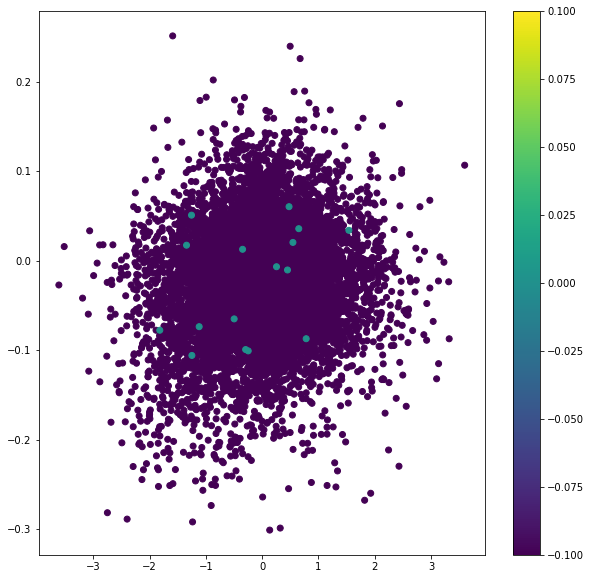

In [19]:
#imgs, labels = next(iter(test_dataloader))
plt.figure(figsize=(10, 10))

for imgs, labels in test_dataloader:
  img = imgs.to(device)
  x, x_encoded_mean, x_encoded_log_var = model.encoder.encode(imgs)

  x_encoded_mean = x_encoded_mean.cpu().detach().numpy()
  plt.scatter(x_encoded_mean[:,0], x_encoded_mean[:,1], c=labels)

plt.colorbar()
plt.savefig("encoding.png")

In [20]:
# REAL SAMPLES
num_samples = 16

test_data, test_labels = next(iter(test_dataloader))

plot_data(name + '_Real_images_test_data_', num_samples, test_data, test_labels)

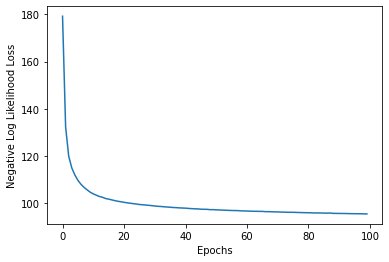

[179.23666930137693, 132.29202298800965, 119.91015895248374, 114.92954844404059, 111.9429073967897, 109.65903974372102, 107.95151668070527, 106.65521880244965, 105.60000813281749, 104.62516357343824, 103.90437118842473, 103.33502518246546, 102.79556592468106, 102.45764153326868, 101.93591731039764, 101.6778041517643, 101.36437725837884, 101.03461388980641, 100.77114377424235, 100.56518547858118, 100.31946739333365, 100.1228927358642, 99.92996442165521, 99.76515894350798, 99.60738443047799, 99.388562556118, 99.3063841622199, 99.16081849510408, 99.05257124059341, 98.92092928679094, 98.76776842083163, 98.63996314514628, 98.55321852935245, 98.4297036563649, 98.33904125867292, 98.23246768063596, 98.12460763253215, 98.06695330295416, 97.96308109644428, 97.9028913883297, 97.8447803292433, 97.73445932334646, 97.64341197294347, 97.56238396881182, 97.53238436998919, 97.39944002390517, 97.3685434053621, 97.34781326723221, 97.21387804621625, 97.21730588830036, 97.1277010593268, 97.08797113364919, 

In [21]:
# plt.ion()

fig = plt.figure()
plt.plot(train_loss_avgs)
plt.xlabel('Epochs')
plt.ylabel('Negative Log Likelihood Loss')
plt.show()

print(train_loss_avgs)

In [22]:
f = open(name + '_Model_Description.txt', "w")

f.write("VAE \n---------------------------------\n"
        "Dataset:\n" + str(train_dataloader.dataset)+ "\n"+
        "- Batch Size: "+ str(batch_size) + "\n"+
        "- Likelihood: "+ likelihood_type + "\n"+
        "- Prior Distribution: "+ prior_distribution + "\n"
        "- Number of Values: "+ str(num_vals) + "\n"+
        "- Number of Latents: " + str(L) + "\n\n"+
        "Model:\n" + str(model) + "\n\n"+
        "Optimizer:\n"+ str(optimizer) + "\n"+
        "- Number of Epochs: "+ str(num_epochs) + "\n\n"+
        "Results:\n-------------------------------\n"
        "- Average Training Loss: " + str(train_loss_avgs[-1]) + "\n"+
        "- Average Validation Loss: " + str(val_loss_avgs[-1]) + "\n"+
        "- Average Test Loss: " + str(test_loss))
f.close()